In [1217]:
!pip3 install pmdarima

Defaulting to user installation because normal site-packages is not writeable


### Importing the required libaries

In [1218]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

### Reading the CSV file (dataset)

In [1219]:
dataset = pd.read_csv("dps_dataset.csv")
dataset.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN,NaN,NaN,NaN,NaN


### Dropping the values after 2020

In [1220]:
filtered_dataset = dataset[dataset['JAHR'] <= 2020]

### Keeping the values since 2021 as test dataset

In [1221]:
test_dataset = dataset[dataset['JAHR'] > 2020]

### Visualizing historically the number of accidents per category

In [1222]:
grouped_category_data = filtered_dataset.groupby('MONATSZAHL')['WERT'].sum().reset_index()

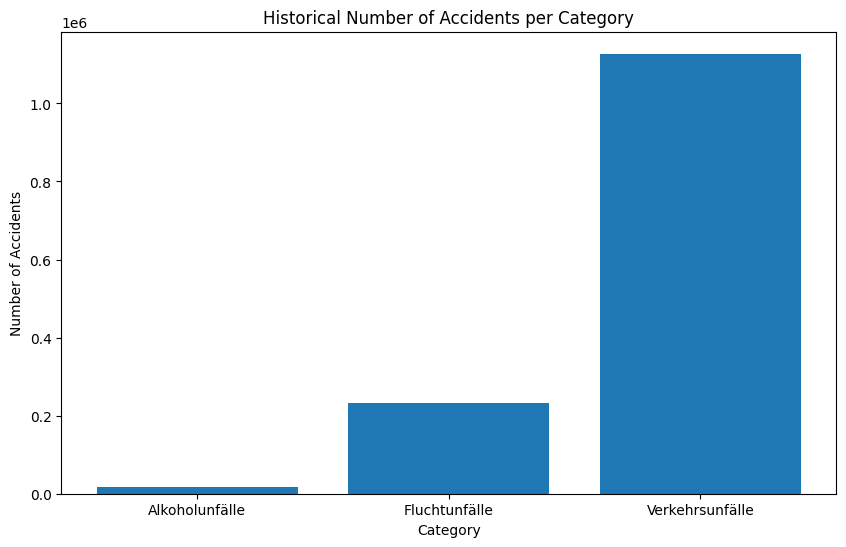

In [1223]:
plt.figure(figsize=(10, 6))
plt.bar(grouped_category_data['MONATSZAHL'], grouped_category_data['WERT'])
plt.title('Historical Number of Accidents per Category')
plt.xlabel('Category')
plt.ylabel('Number of Accidents')
plt.show()

As there is an uneven distribution of accidents for categories, we should look at each of them separately

In [1224]:
grouped_category_date_data = filtered_dataset.groupby(['MONATSZAHL', 'JAHR', 'MONAT'])['WERT'].sum().reset_index()

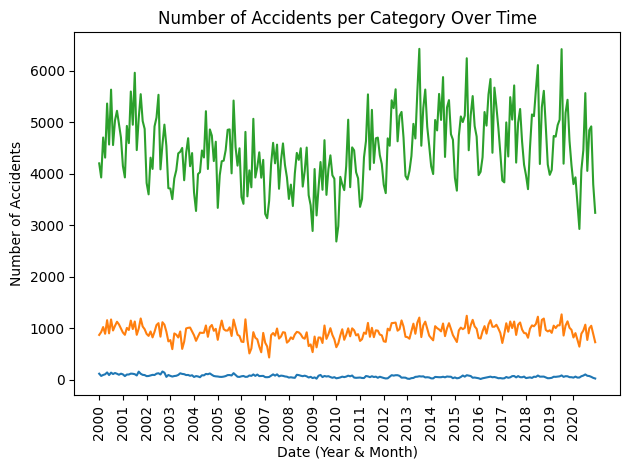

In [1225]:
for category in grouped_category_date_data['MONATSZAHL'].unique():
    category = grouped_category_date_data[grouped_category_date_data['MONATSZAHL'] == category]
    plt.plot(category['JAHR'].astype(str) + '-' + category['MONAT'].astype(str), category['WERT'], label=category)

    # Show only every 12-th tick. That is, one for each year
    n = 12
    plt.xticks(range(0, len(category['JAHR']), n), category['JAHR'][::n])
    plt.xticks(rotation=90)

plt.title('Number of Accidents per Category Over Time')
plt.xlabel('Date (Year & Month)')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

We can see that there is some pattern in the data. But we will need more EDA to understand these patterns and use them to predict future values

### Some more EDA:

#### Checking for any missing values

In [1226]:
filtered_dataset.isna().sum()

MONATSZAHL                         0
AUSPRAEGUNG                        0
JAHR                               0
MONAT                              0
WERT                               0
VORJAHRESWERT                     84
VERAEND_VORMONAT_PROZENT           8
VERAEND_VORJAHRESMONAT_PROZENT    85
ZWOELF_MONATE_MITTELWERT           0
dtype: int64

**VORJAHRESWERT = previous year value**

**VERAEND_VORMONAT_PROZENT = change from previous month in percentange**

**VERAEND_VORJAHRESMONAT_PROZENT = change from previous year month in percentage**

Since we are only interested in the first 5 columns, we can drop the columns that have missing values. If we do not get a satisfactory accuracy, then we can use some imputation techniques to fill these missing values and add them to our prediction model.

##### Keeping only the first 5 columns

In [1227]:
mini_filtered_dataset = filtered_dataset.iloc[:, :5]
mini_filtered_dataset.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
36,Alkoholunfälle,insgesamt,2020,202001,28.0
37,Alkoholunfälle,insgesamt,2020,202002,40.0
38,Alkoholunfälle,insgesamt,2020,202003,27.0
39,Alkoholunfälle,insgesamt,2020,202004,26.0
40,Alkoholunfälle,insgesamt,2020,202005,40.0


We can see that the column ```MONAT``` is not exactly the month but is the concatenation of the year and month. We must convert this to contain only the month.

##### Change the Month column

In [1228]:
mini_filtered_dataset['MONAT'] = mini_filtered_dataset['MONAT'].astype(str).str[-2:]
mini_filtered_dataset.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
36,Alkoholunfälle,insgesamt,2020,01,28.0
37,Alkoholunfälle,insgesamt,2020,02,40.0
38,Alkoholunfälle,insgesamt,2020,03,27.0
39,Alkoholunfälle,insgesamt,2020,04,26.0
40,Alkoholunfälle,insgesamt,2020,05,40.0


We also observe that the indices are not ordered. So we can either index it based on year and month (since we will be working with time-series models) or just have a regular integer indexing.

##### Checking the unique values in AUSPRAEGUNG

In [1229]:
mini_filtered_dataset.AUSPRAEGUNG.unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

Since there are only 3 accident sub-categories in each, we can index this too to make our time-series index unique.

##### Reset the index using Datetime indexing

In [1230]:
mini_filtered_dataset.shape

(1764, 5)

In [1231]:
mini_filtered_dataset['DATE'] = pd.to_datetime(mini_filtered_dataset['JAHR'].astype(str) + '-' + mini_filtered_dataset['MONAT'].astype(str), format='%Y-%m')
mini_filtered_dataset.set_index(['DATE'], inplace=True)

In [1232]:
mini_filtered_dataset.drop(['JAHR', 'MONAT'], axis=1, inplace=True)
mini_filtered_dataset.sort_index(inplace=True)
mini_filtered_dataset.head()

,MONATSZAHL,AUSPRAEGUNG,WERT
DATE,,,
2000-01-01,Fluchtunfälle,Verletzte und Getötete,34.0
2000-01-01,Verkehrsunfälle,mit Personenschäden,321.0
2000-01-01,Alkoholunfälle,insgesamt,78.0
2000-01-01,Fluchtunfälle,insgesamt,835.0
2000-01-01,Verkehrsunfälle,insgesamt,3448.0


In [1233]:
mini_filtered_dataset.shape

(1764, 3)

Now that the dataset looks cleaner than before, we can do some basic statistics to learn more about it.

#### Some general statistics

In [1234]:
mini_filtered_dataset.describe()

,WERT
count,1764.000000
mean,780.292517
std,1180.838117
min,0.000000
25%,38.750000
50%,360.000000
75%,813.250000
max,4763.000000


##### Splitting each category

In [1235]:
mini_filtered_dataset.MONATSZAHL.unique()

array(['Fluchtunfälle', 'Verkehrsunfälle', 'Alkoholunfälle'], dtype=object)

We have 3 categories: Alkoholunfälle (alcohol accidents), Fluchtunfälle (escape accidents), Verkehrsunfälle (traffic accidents)

In [1236]:
alcohol_accidents = mini_filtered_dataset[mini_filtered_dataset['MONATSZAHL'] == "Alkoholunfälle"]
escape_accidents = mini_filtered_dataset[mini_filtered_dataset['MONATSZAHL'] == "Fluchtunfälle"]
traffic_accidents = mini_filtered_dataset[mini_filtered_dataset['MONATSZAHL'] == "Verkehrsunfälle"]

Now that we have split the datasets into 3 categories, we can drop the MONATSZAHL column from the dataset

In [1237]:
alcohol_accidents = alcohol_accidents.drop(['MONATSZAHL'], axis=1).copy()
escape_accidents = escape_accidents.drop(['MONATSZAHL'], axis=1).copy()
traffic_accidents = traffic_accidents.drop(['MONATSZAHL'], axis=1).copy()

In [1238]:
alcohol_accidents.head()

,AUSPRAEGUNG,WERT
DATE,,
2000-01-01,insgesamt,78.0
2000-01-01,Verletzte und Getötete,37.0
2000-02-01,insgesamt,53.0
2000-02-01,Verletzte und Getötete,19.0
2000-03-01,insgesamt,73.0


We now have a clean dataset to perform time-series analysis on